## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.


1. Загрузите и подготовьте данные.
    - Импортируем библиотеки [тут](#step1.1)
    - Загружаем данные [тут](#step1.2)
    - Изучаем данные [тут](#step1.3)
<br/>


2. Предобработка данных [тут](#step2)<br/>
    - Очищаем данные [тут](#step2.1)<br/>
    - Разбиваем данные на выборки [тут](#step2.2)<br/>

3. Обучение моделей [тут](#step3)
    - CatBoost [тут](#step3.1)
    - TF-IDF [тут](#step3.2)<br/>
        - LogisticRegression [тут](#step3.2.1)
        - LinearSVC [тут](#step3.2.2)
        - LightGBM [тут](#step3.2.3)
            - LightGBM + GridSearchCV [тут](#step3.2.3.1)
    - BERT [тут](#step3.4)
        - Инициализация [тут](#step3.4.1)
        - Создание эмбеддингов [тут](#step3.4.2)
        - LogisticRegression [тут](#step3.4.3)
        - LinearSVC [тут](#step3.4.4)
        - LightGBM [тут](#step3.4.5)
        - CatBoost [тут](#step3.4.6)

4. [Итоги.](#step4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install --upgrade pip --user
!pip install torch
!pip install transformers
!pip install tensorflow --user
!pip install bert-tensorflow
!pip install keras
!pip install keras-bert
!pip install tokenization
!pip install catboost

     |████████████████████████████████| 12.7MB 259kB/s 
     |████████████████████████████████| 460kB 51.3MB/s 
     |████████████████████████████████| 9.1MB 48.2MB/s 
     |████████████████████████████████| 1.1MB 49.7MB/s 
     |████████████████████████████████| 122kB 55.2MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=bf99a35ebf59470f01d7607e9eb8d174c87f4ba3d4b98b04c47f81c6c51f23c1
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: smart-open 4.2.0
    Uninstalling smart-open-4.2.0:
      Successfully uninstalled smart-open-4.2.0
  Found existing installation: thinc 7.4.0
    U

### Импортируем библиотеки <a id="step1.1"></a>

In [ ]:
import pandas as pd
import numpy as np
import pymystem3
import nltk
import torch
import transformers
import spacy
import tensorflow
import tokenization
import sys
import codecs
import seaborn as sns
import re


import time
pd.set_option('display.precision',3)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords

from pymystem3 import Mystem

from tqdm import notebook

from bert.tokenization import FullTokenizer
from transformers import BertForQuestionAnswering, BertConfig, BertTokenizer
from keras_bert import load_trained_model_from_checkpoint

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Загружаем данные<a id="step1.2"></a>



In [ ]:
try:
    folder = 'C:/Users/timur/Я.Практикум/Проекты/Data Science/Отредактировать/13. Машинное обучение для текстов. BERT/'
    df = pd.read_csv(folder + 'toxic_comments.csv')

except FileNotFoundError:

    folder = '/content/drive/MyDrive/Colab Notebooks/BERT_project/'
    df = pd.read_csv(folder + 'toxic_comments.csv')

except:
  
    df = pd.read_csv('/datasets/toxic_comments.csv')

Посмотрим на данные<a id="step1.3"></a>

In [ ]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
df.tail()

,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [ ]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков нет

In [ ]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Видим дисбаланс классов

Посмотрим на длину комментариев

In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

In [ ]:
df['text_length'].describe()

count    159571.000
mean        394.073
std         590.720
min           6.000
25%          96.000
50%         205.000
75%         435.000
max        5000.000
Name: text_length, dtype: float64

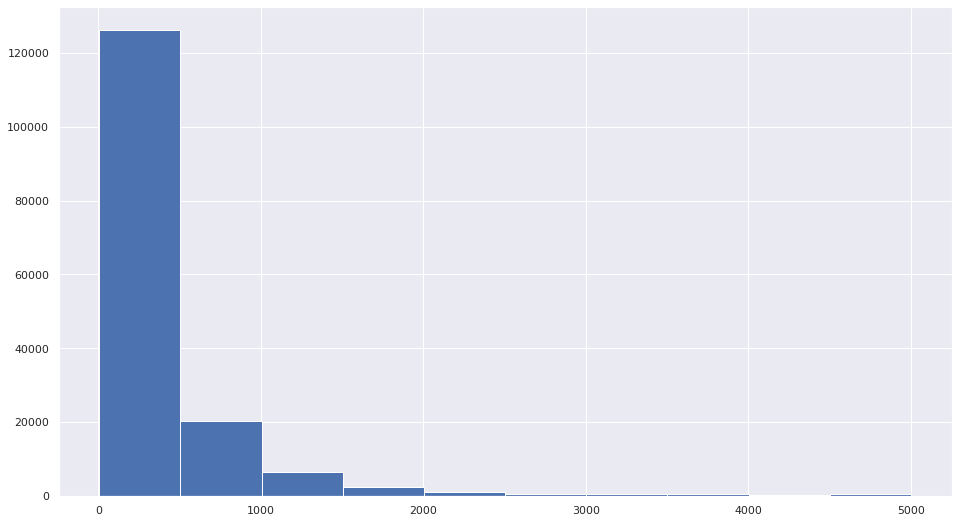

In [ ]:
sns.set()
df['text_length'].hist(figsize=(16, 9))
plt.show()

Проверим, есть ли другие языки в комментах, кроме английского.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
nlp('He matches this background colour').lang_

'en'

doc = df['text'].apply(
  lambda x: nlp(x).lang_)

doc.value_counts()

В наборе только тексты на английском языке.

## Предобработка данных <a id="step2"></a>

### Очистим данные <a id="step2.1"></a>

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
clean_text(df['text'][0])

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

### Разобъем данные на выборки <a id="step2.2"></a>

In [ ]:
df

,text,toxic,text_length,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,112,d aww he matches this background colour i am s...
2,"Hey man, I'm really not trying to edit war. It...",0,233,hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,more i cannot make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,67,you sir are my hero any chance you remember wh...
...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,295,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,99,you should be ashamed of yourself that is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,81,spitzer umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,116,and it looks like it was actually you who put ...


Сохраним тестово-валидационную выборку, для предтестового обучения модели

In [ ]:
train_val = df.sample(frac=0.8, random_state=42).copy()
test = df[~df.index.isin(train_val.index)].copy()

In [ ]:
train = train_val.sample(frac=0.75, random_state=42).copy()
val = train_val[~train_val.index.isin(train.index)].copy()

In [ ]:
len(df) == len(train) + len(val) + len(test)

True

In [ ]:
len(train_val) == len(train) + len(val)

True

# Обучение моделей <a id="step3"></a>

## CatBoost<a id="step3.1"></a>

In [ ]:
cat_X = ['clean_text']
text_features=['clean_text']
cat_y = ['toxic']
cat_model = CatBoostClassifier(verbose=100, text_features=text_features)

In [ ]:
start_time = time.time()
cat_model.fit(train[cat_X], train[cat_y],
             eval_set=(val[cat_X], val[cat_y]))
learn_time = time.time() - start_time

Learning rate set to 0.097778
0:	learn: 0.5720297	test: 0.5703555	best: 0.5703555 (0)	total: 338ms	remaining: 5m 37s
100:	learn: 0.1262761	test: 0.1226002	best: 0.1226002 (100)	total: 30s	remaining: 4m 27s
200:	learn: 0.1152985	test: 0.1174715	best: 0.1174715 (200)	total: 59.8s	remaining: 3m 57s
300:	learn: 0.1092192	test: 0.1157989	best: 0.1157989 (300)	total: 1m 28s	remaining: 3m 26s
400:	learn: 0.1046220	test: 0.1147787	best: 0.1147761 (399)	total: 1m 57s	remaining: 2m 55s
500:	learn: 0.1005765	test: 0.1138927	best: 0.1138738 (497)	total: 2m 26s	remaining: 2m 25s
600:	learn: 0.0971981	test: 0.1134864	best: 0.1134864 (600)	total: 2m 54s	remaining: 1m 56s
700:	learn: 0.0942861	test: 0.1132618	best: 0.1132527 (698)	total: 3m 23s	remaining: 1m 26s
800:	learn: 0.0917069	test: 0.1131171	best: 0.1130916 (780)	total: 3m 51s	remaining: 57.5s
900:	learn: 0.0892317	test: 0.1129589	best: 0.1129411 (887)	total: 4m 19s	remaining: 28.6s
999:	learn: 0.0868609	test: 0.1126837	best: 0.1126781 (996)	t

In [ ]:
val_preds = cat_model.predict(val[cat_X])
f1_val = f1_score(val[cat_y], val_preds)
f1_val

0.7756299620296858

In [ ]:
test_preds = cat_model.predict(test[cat_X])
f1_test = f1_score(test[cat_y], test_preds)

In [ ]:
Name = ['CatBoostClassifier']
F1_score_validation = [f1_val]
F1_score_test = [f1_test]
Learn_Time = [learn_time]

## TF-IDF <a id="step3.2"></a>

Создадим счетчик слов

In [ ]:
vect = TfidfVectorizer(stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
train_val_X = vect.fit_transform(train_val['clean_text'])
train_val_y = train_val['toxic']
test_X = vect.transform(test['clean_text'])
test_y = test['toxic']

In [ ]:
X = vect.fit_transform(train['clean_text'])
y = train['toxic']
val_X = vect.transform(val['clean_text'])
val_y = val['toxic']

### LogisticRegression <a id="step3.2.1"></a>

In [ ]:
logreg = LogisticRegression()

Подберем оптимальную степень регуляризации при помощи GridSearchCV

param = {'C': range (1,20, 2)}

grid = GridSearchCV(logreg, param, scoring='f1', cv=4)
start_time = time.time()
grid.fit(X, y)
gridsearch_time = time.time() - start_time

gridsearch_time, grid.best_params_

Посмотрим на целевую метрику на валидационном сете

In [ ]:
logreg = LogisticRegression(C=19)
logreg.fit(X, y)
val_preds = logreg.predict(val_X)
f1_val = f1_score(val_y, val_preds)
f1_val

0.7708405999302407

Необходимый для выполнения поставленной задачи минимум достугнут(f1 > 0.75). Попробуем его побить другими моделями. 

Для максимально объективного решения, показатели моделей на тестовой выборке посмотрим только в финальной таблице.

Обучаем логистическую регрессию на тренировочно-валидационном датасете.

In [ ]:
logreg = LogisticRegression(C=19)

start_time = time.time()
logreg.fit(train_val_X, train_val_y)
learn_time = time.time() - start_time

test_preds = logreg.predict(test_X)
f1_test = f1_score(test_y, test_preds)

In [ ]:
Name.append('LogisticRegression')
F1_score_validation.append(f1_val)
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

### LinearSVC<a id="step3.2.2"></a>

In [ ]:
svc = LinearSVC(C=1)

In [ ]:
param = {'C': range (1,20, 2)}

grid = GridSearchCV(svc, param, scoring='f1', cv=4)
start_time = time.time()
grid.fit(X, y)
gridsearch_time = time.time() - start_time

gridsearch_time, grid.best_params_

(59.118693590164185, {'C': 1})

In [ ]:
svc.fit(X, y)
val_preds = svc.predict(val_X)
f1_val = f1_score(val_y, val_preds)
f1_val

0.7720832604512857

In [ ]:
Name.append('LinearSVC')
F1_score_validation.append(f1_val)
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

### LightGBM<a id="step3.2.3"></a>

In [ ]:
lgbm = LGBMClassifier(metric = 'f1_score')

In [ ]:
lgbm.fit(X, y, eval_set=(val_X, val_y))
lgbm_val_preds = lgbm.predict(val_X)
f1_val = f1_score(val_y, lgbm_val_preds)
f1_val

0.7367070040337367

Показатель целевой метрики не очень хорош, требуемые f1>0,75 не достигнуты, значит:
- Обучим "коробочную" LightGBM на тренировочно-валидационном сете
- сохраним показатели на тестах 
- попробуем подтягуть LightGBM при помощи GridSearchCV

In [ ]:
start_time = time.time()
lgbm.fit(train_val_X, train_val_y)
learn_time = time.time() - start_time
lgbm_preds = lgbm.predict(test_X)
f1_test = f1_score(lgbm_preds, test_y)

In [ ]:
Name.append('LGBMClassifier')
F1_score_validation.append(f1_val)
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

#### LGBM + GridSearchCV<a id="step3.2.3.1"></a>

lgbm_gs = LGBMClassifier(metric = 'f1_score')

param = {'num_leaves': [250, 500, 750, 1000],
         'max_depth': range (1,13, 2),
         'learning_rate': [0.01, 0.05, 0.1, 0.25]}

grid = GridSearchCV(lgbm_gs, param, scoring='f1', cv=5)
start_time = time.time()
grid.fit(X, y)
gridsearch_time = time.time() - start_time

gridsearch_time, grid.best_params_

In [ ]:
lgbm_gs = LGBMClassifier(learning_rate=0.25, max_depth=11, num_leaves=250, metric = 'f1_score')
lgbm_gs.fit(X, y, eval_set=(val_X, val_y))
lgbm_gs_val_preds = lgbm_gs.predict(val_X)

f1_val = f1_score(lgbm_gs_val_preds, val_y)
f1_val

0.7405643092707951

In [ ]:
lgbm_gs = LGBMClassifier(learning_rate=0.25, max_depth=11, num_leaves=250, metric = 'f1_score')
start_time = time.time()
lgbm_gs.fit(train_val_X, train_val_y)
learn_time = time.time() - start_time

lgbm_gs_preds = lgbm_gs.predict(test_X)
f1_test = f1_score(lgbm_gs_preds, test_y)

In [ ]:
Name.append('LGBMClassifier+GridSearchCV')
F1_score_validation.append(f1_val)
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

### Финальная таблица на TF-IDF<a id="step3.2.4"></a>

In [ ]:
final_table = pd.DataFrame([F1_score_validation, F1_score_test, Learn_Time]).T

final_table.columns = ['F1_score_validation', 'F1_score_test','Learn_time']
final_table.index = Name
final_table

,F1_score_validation,F1_score_test,Learn_time
CatBoostClassifier,0.776,0.774,296.929
LogisticRegression,0.771,0.774,8.548
LinearSVC,0.772,0.774,8.548
LGBMClassifier,0.737,0.744,78.819
LGBMClassifier+GridSearchCV,0.741,0.740,45.167


## BERT <a id="step3.4"></a>

###Инициализируем токенизатор и предобученную модель<a id="step3.4.1"></a>

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
model = model.cuda()

In [ ]:
tokenizer.encode('feel good', add_special_tokens=True)

[101, 2514, 2204, 102]

In [ ]:
df_toknd = df['clean_text'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

In [ ]:
df_toknd

0         [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1         [101, 1040, 22091, 2860, 2002, 3503, 2023, 428...
2         [101, 4931, 2158, 1045, 2572, 2428, 2025, 2667...
3         [101, 2062, 1045, 3685, 2191, 2151, 2613, 1569...
4         [101, 2017, 2909, 2024, 2026, 5394, 2151, 3382...
                                ...                        
159566    [101, 1998, 2005, 1996, 2117, 2051, 1997, 4851...
159567    [101, 2017, 2323, 2022, 14984, 1997, 4426, 200...
159568    [101, 13183, 6290, 26114, 2045, 2015, 2053, 50...
159569    [101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...
159570    [101, 1998, 1045, 2428, 2079, 2025, 2228, 2017...
Name: clean_text, Length: 159571, dtype: object

In [ ]:
max_len = 0
for i in df_toknd:
    if len(i) > max_len:
        max_len = len(i)

In [ ]:
padded = np.array([i + [0]*(max_len - len(i)) for i in df_toknd.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
padded.shape, attention_mask.shape

((159571, 512), (159571, 512))

In [ ]:
batch_size = 100

### Создаем эмбеддинги<a id="step3.4.2"></a>

In [ ]:
embeddings = []
 
for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
 
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
 
    embeddings.append(batch_embeddings[0][:,0,:].to('cpu'))

In [ ]:
features = np.concatenate(embeddings)
target = df['toxic']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

### BERT+LogisticRegression<a id="step3.4.3"></a>

In [ ]:

logreg.fit(train_val_X, train_val_y)


LogisticRegression(C=19, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = LogisticRegression(C=19)
start_time = time.time()
model.fit(features_train, target_train)
learn_time = time.time() - start_time
train_pred = model.predict(features_test)
f1_test = f1_score(train_pred, target_test)

In [ ]:
Name.append('BERT+LogisticRegression')
F1_score_validation.append('-')
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

### BERT+LinearSVC<a id="step3.4.4"></a>

In [ ]:
svc = LinearSVC(C=1)
start_time = time.time()
svc.fit(features_train, target_train)
learn_time = time.time() - start_time
train_pred = svc.predict(features_test)
f1_test = f1_score(train_pred, target_test)

In [ ]:
Name.append('BERT+LinearSVC')
F1_score_validation.append('-')
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

Выделим валидационный сет для бустинговых алгоритмов

In [ ]:
features_boost_train, features_boost_val, target_boost_train, target_boost_val = train_test_split(
    features_train, target_train, test_size=0.25, random_state=42)

### BERT+LGBMClassifier<a id="step3.4.5"></a>

In [ ]:
bert_lgbm = LGBMClassifier(metric = 'f1_score')
start_time = time.time()
bert_lgbm.fit(features_boost_train, target_boost_train, eval_set=(features_boost_val, target_boost_val))
learn_time = time.time() - start_time
lgbm_preds = bert_lgbm.predict(features_test)
f1_test = f1_score(target_test, lgbm_preds)

In [ ]:
Name.append('BERT+LGBMClassifier')
F1_score_validation.append('-')
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

### BERT+CatBoost<a id="step3.4.6"></a>

In [ ]:
cat_model = CatBoostClassifier(verbose=100)

In [ ]:
start_time = time.time()
cat_model.fit(features_boost_train, target_boost_train, eval_set=(features_boost_val, target_boost_val))
learn_time = time.time() - start_time

Learning rate set to 0.097778
0:	learn: 0.5780379	test: 0.5782525	best: 0.5782525 (0)	total: 569ms	remaining: 9m 28s
100:	learn: 0.1451608	test: 0.1584843	best: 0.1584843 (100)	total: 43.7s	remaining: 6m 29s
200:	learn: 0.1267775	test: 0.1514772	best: 0.1514772 (200)	total: 1m 23s	remaining: 5m 30s
300:	learn: 0.1130842	test: 0.1484555	best: 0.1484555 (300)	total: 2m 2s	remaining: 4m 45s
400:	learn: 0.1019716	test: 0.1468923	best: 0.1468923 (400)	total: 2m 41s	remaining: 4m 1s
500:	learn: 0.0924598	test: 0.1458874	best: 0.1458874 (500)	total: 3m 21s	remaining: 3m 20s
600:	learn: 0.0842322	test: 0.1450723	best: 0.1450723 (600)	total: 4m	remaining: 2m 39s
700:	learn: 0.0771370	test: 0.1444627	best: 0.1444627 (700)	total: 4m 38s	remaining: 1m 58s
800:	learn: 0.0707795	test: 0.1438296	best: 0.1438296 (800)	total: 5m 16s	remaining: 1m 18s
900:	learn: 0.0651272	test: 0.1434411	best: 0.1434361 (897)	total: 5m 54s	remaining: 39s
999:	learn: 0.0598232	test: 0.1434757	best: 0.1433175 (963)	total

In [ ]:
val_preds = cat_model.predict(features_boost_val)
f1_val = f1_score(target_boost_val, val_preds)
f1_val

0.7019890864284458

In [ ]:
test_preds = cat_model.predict(features_test)
f1_test = f1_score(target_test, test_preds)

In [ ]:
Name.append('BERT+CatBoostClassifier')
F1_score_validation.append(f1_val)
F1_score_test.append(f1_test)
Learn_Time.append(learn_time)

# Итоги<a id="step4"></a>

## Финальная таблица моделей<a id="step4.1"></a>

In [ ]:
final_table = pd.DataFrame([F1_score_validation, F1_score_test, Learn_Time]).T

final_table.columns = ['F1_score_validation', 'F1_score_test','Learn_time']
final_table.index = Name
final_table

,F1_score_validation,F1_score_test,Learn_time
CatBoostClassifier,0.776,0.774,297
LogisticRegression,0.771,0.774,8.55
LinearSVC,0.772,0.774,8.55
LGBMClassifier,0.737,0.744,78.8
LGBMClassifier+GridSearchCV,0.741,0.74,45.2
BERT+LogisticRegression,-,0.724,15.5
BERT+LinearSVC,-,0.715,183
BERT+LGBMClassifier,-,0.676,88.3


## Итоги исследования<a id="step4.2"></a>

Провели большой обзор разных моделей сначала на базе TF-IDF, потом на базе предобученной нейронной модели Bert.

Лучшие результаты получили в связке алгоритма TF-IDF и моделями LogisticRegression, LinearSVC - 0,774. 
Такие же результаты показал коробочный CatBoostClassifier с указанием текстовых переменных.

CatBoostClassifier значительно быстрее запустить, т.к. не требуется практически никакой предобработки текста. 
Логистическая регрессия и метод опорных векторов, в свою очередь, являются более интерпретируемыми, по сравнению с CatBoostClassifier.

Обучение на эмбеддингах, полученных с помощью предобученной нейронки BERT, показало худшее качество на данном датасете.